# GENERATOR
We need to compute:
1. Sample a N(100) vector
2. run forward pass
3. calculate loss
4. update weights

# Discriminator
1. Sample 16 MNIST data
2. Sample 16 generator images
3. Label and shuffle
4. Forward
5. Loss
6. Update

In [1]:
from data_setup import create_dataloaders
from utils import save_image_batch, TrainStepReturn, _gradient_penalty
from tqdm import tqdm
from torch.optim import Adam

from model import GeneratorMLP, DiscriminatorMLP
import matplotlib.pyplot as plt
import torch

torch.manual_seed(42)

Using device: mps
Sampled z: torch.Size([16, 100])
Generated images: torch.Size([16, 1, 28, 28])


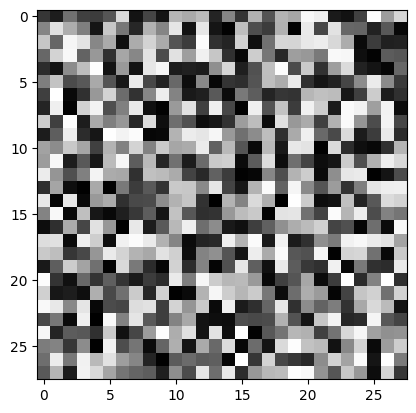

In [2]:
# Tensor sizes:
# B = Batch size
# S = Random vector sample size
# I = img size

SAMPLE_Z_SIZE: int = 100
BATCH_SIZE: int = 16
DEVICE: str = "mps" if torch.backends.mps.is_available() else "cpu"
EPOCHS: int = 100

print(f"Using device: {DEVICE}")
z_B_S: torch.Tensor = torch.normal(mean=0, std=1, size=(BATCH_SIZE, SAMPLE_Z_SIZE)).to(DEVICE)
print(f"Sampled z: {z_B_S.shape}")

# Forward pass
generator: GeneratorMLP = GeneratorMLP().to(DEVICE)
generated_images_B_1_I_I: torch.Tensor = generator(z_B_S)

print(f"Generated images: {generated_images_B_1_I_I.shape}")
plt.imshow(generated_images_B_1_I_I[0].detach().cpu().numpy().reshape(28, 28), cmap="gray")

In [3]:
train_dataloader = create_dataloaders(data_dir="data", batch_size=BATCH_SIZE, num_workers=1)

for i, (real_images, _) in enumerate(train_dataloader):
    print(real_images.shape)
    break

/Users/robertomartins/Developer/torch/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([16, 1, 28, 28])


In [4]:
discriminator: DiscriminatorMLP = DiscriminatorMLP().to(DEVICE)
generator: GeneratorMLP = GeneratorMLP().to(DEVICE)

discriminator_optimizer: Adam = Adam(discriminator.parameters(), lr=0.001)
generator_optimizer: Adam = torch.optim.Adam(generator.parameters(), lr=0.001)

In [5]:
def wasserstein_loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    return -1 * (torch.mean(y_true) - torch.mean(y_pred))


def generator_loss(y_pred):
    return -torch.mean(y_pred)

In [6]:
def train_step(generator, discriminator, real_images, sampled_z, discriminator_optimizer, generator_optimizer, train_generator=False, device=DEVICE,) -> TrainStepReturn:
    discriminator_optimizer.zero_grad()

    # 1. Move data to device
    real_images_B_1_I_I: torch.Tensor = real_images.to(device) # [16, 1, 28, 28]
    
    # The detach() prevents from saving grads when we do not want to train
    fake_images_B_1_I_I: torch.Tensor = generator(sampled_z.to(device)).detach() # [16, 1, 28, 28]

    # 2. Forward pass
    real_preds_B_1_1_1: torch.Tensor = discriminator(real_images_B_1_I_I) # [16, 1, 1, 1]
    fake_preds_B_1_1_1: torch.Tensor = discriminator(fake_images_B_1_I_I) # [16, 1, 1, 1]

    # 3. Calculate loss
    discriminator_loss: torch.scalar_tensor = wasserstein_loss(real_preds_B_1_1_1, fake_preds_B_1_1_1)

    gp_lambda: float = 10.0
    gp = _gradient_penalty(discriminator, real_images_B_1_I_I, fake_images_B_1_I_I, device)
    discriminator_loss = discriminator_loss + gp_lambda * gp
    # 4. Backward pass
    discriminator_loss.backward()
    discriminator_optimizer.step()

    gen_loss: float | None = None
    if train_generator:
        generator_optimizer.zero_grad()
        fake_images_B_1_I_I: torch.Tensor = generator(sampled_z.to(device)) # [16, 1, 28, 28]
        fake_preds_B_1_1_1: torch.Tensor = discriminator(fake_images_B_1_I_I) # [16, 1, 1, 1]
        gen_loss: torch.scalar_tensor = generator_loss(fake_preds_B_1_1_1)
        gen_loss.backward()
        generator_optimizer.step()
        gen_loss: float = float(gen_loss.item())

    return TrainStepReturn(
        total_loss=float(discriminator_loss.item()),
        gen_loss=gen_loss
    )

In [7]:
def train(generator, discriminator, dataloader, discriminator_optimizer, generator_optimizer, epochs=EPOCHS, device=DEVICE,):

    train_loss: list[list[float]] = []
    train_gen_loss: list[list[float]] = []

    for epoch in range(epochs):

        generator.eval()
        with torch.no_grad():
            save_image_batch(generator(z_B_S.to(DEVICE)).detach(), iter=epoch, out_dir="valid")
        generator.train()

        epoch_loss: list[float] = []
        gen_loss_list: list[float] = []

        # Training loop
        for i, (real_images, _) in enumerate(tqdm(dataloader)):
            z_sample_B_S: torch.Tensor = torch.normal(
                mean=0,
                std=1,
                size=(BATCH_SIZE, SAMPLE_Z_SIZE),
            )

            train_generator: bool = (i % 5 == 0)

            train_step_return = train_step(
                generator,
                discriminator,
                real_images,
                z_sample_B_S,
                discriminator_optimizer,
                generator_optimizer,
                train_generator,
                device
            )

            train_step_loss: float = train_step_return.total_loss
            if train_generator:
                gen_step_loss: float = train_step_return.gen_loss
                gen_loss_list.append(gen_step_loss)
            epoch_loss.append(train_step_loss)

        print(
            f"Epoch: {epoch}, "
            f"Mean train_loss: {sum(epoch_loss) / len(epoch_loss):.2f}, "
            f"Mean gen_loss: {sum(gen_loss_list) / len(gen_loss_list):.2f}"
        )
        train_loss.append(epoch_loss)
        train_gen_loss.append(gen_loss_list)
        
        # at epoch end, also use z_B_S for consistency (or drop this second save):
        generator.eval()
        with torch.no_grad():
            save_image_batch(generator(z_sample_B_S.to(DEVICE)).detach(), iter=epoch, out_dir="training")
        generator.train()

In [8]:
train(generator, discriminator, train_dataloader, discriminator_optimizer, generator_optimizer)

100%|██████████| 3750/3750 [00:29<00:00, 128.64it/s]


Epoch: 0, Mean train_loss: -3.15, Mean gen_loss: -0.04


100%|██████████| 3750/3750 [00:27<00:00, 136.58it/s]


Epoch: 1, Mean train_loss: -2.31, Mean gen_loss: 1.67


100%|██████████| 3750/3750 [00:27<00:00, 138.15it/s]


Epoch: 2, Mean train_loss: -2.12, Mean gen_loss: 2.00


100%|██████████| 3750/3750 [00:27<00:00, 136.68it/s]


Epoch: 3, Mean train_loss: -1.92, Mean gen_loss: 1.23


100%|██████████| 3750/3750 [00:27<00:00, 136.78it/s]


Epoch: 4, Mean train_loss: -1.72, Mean gen_loss: 0.60


100%|██████████| 3750/3750 [00:27<00:00, 137.03it/s]


Epoch: 5, Mean train_loss: -1.55, Mean gen_loss: -0.06


100%|██████████| 3750/3750 [00:27<00:00, 136.23it/s]


Epoch: 6, Mean train_loss: -1.44, Mean gen_loss: -0.70


100%|██████████| 3750/3750 [00:27<00:00, 135.60it/s]


Epoch: 7, Mean train_loss: -1.32, Mean gen_loss: -1.07


100%|██████████| 3750/3750 [00:27<00:00, 135.89it/s]


Epoch: 8, Mean train_loss: -1.21, Mean gen_loss: -1.44


100%|██████████| 3750/3750 [00:27<00:00, 134.05it/s]


Epoch: 9, Mean train_loss: -1.14, Mean gen_loss: -1.60


100%|██████████| 3750/3750 [00:27<00:00, 135.74it/s]


Epoch: 10, Mean train_loss: -1.07, Mean gen_loss: -1.60


100%|██████████| 3750/3750 [00:27<00:00, 134.61it/s]


Epoch: 11, Mean train_loss: -1.02, Mean gen_loss: -1.82


100%|██████████| 3750/3750 [00:27<00:00, 134.46it/s]


Epoch: 12, Mean train_loss: -1.00, Mean gen_loss: -1.86


100%|██████████| 3750/3750 [00:28<00:00, 131.61it/s]


Epoch: 13, Mean train_loss: -0.95, Mean gen_loss: -2.29


100%|██████████| 3750/3750 [00:28<00:00, 133.42it/s]


Epoch: 14, Mean train_loss: -0.91, Mean gen_loss: -2.00


100%|██████████| 3750/3750 [00:28<00:00, 131.05it/s]


Epoch: 15, Mean train_loss: -0.85, Mean gen_loss: -2.37


100%|██████████| 3750/3750 [00:28<00:00, 131.86it/s]


Epoch: 16, Mean train_loss: -0.83, Mean gen_loss: -2.42


100%|██████████| 3750/3750 [00:28<00:00, 133.08it/s]


Epoch: 17, Mean train_loss: -0.80, Mean gen_loss: -2.43


100%|██████████| 3750/3750 [00:28<00:00, 131.18it/s]


Epoch: 18, Mean train_loss: -0.76, Mean gen_loss: -2.33


100%|██████████| 3750/3750 [00:28<00:00, 133.12it/s]


Epoch: 19, Mean train_loss: -0.73, Mean gen_loss: -2.26


100%|██████████| 3750/3750 [00:28<00:00, 132.58it/s]


Epoch: 20, Mean train_loss: -0.70, Mean gen_loss: -2.32


100%|██████████| 3750/3750 [00:28<00:00, 130.50it/s]


Epoch: 21, Mean train_loss: -0.69, Mean gen_loss: -2.36


100%|██████████| 3750/3750 [00:28<00:00, 131.57it/s]


Epoch: 22, Mean train_loss: -0.68, Mean gen_loss: -2.45


100%|██████████| 3750/3750 [00:28<00:00, 130.86it/s]


Epoch: 23, Mean train_loss: -0.64, Mean gen_loss: -2.41


100%|██████████| 3750/3750 [00:28<00:00, 132.76it/s]


Epoch: 24, Mean train_loss: -0.62, Mean gen_loss: -2.44


100%|██████████| 3750/3750 [00:28<00:00, 133.60it/s]


Epoch: 25, Mean train_loss: -0.62, Mean gen_loss: -2.48


100%|██████████| 3750/3750 [00:27<00:00, 136.67it/s]


Epoch: 26, Mean train_loss: -0.60, Mean gen_loss: -2.43


100%|██████████| 3750/3750 [00:27<00:00, 137.60it/s]


Epoch: 27, Mean train_loss: -0.58, Mean gen_loss: -2.10


100%|██████████| 3750/3750 [00:27<00:00, 136.16it/s]


Epoch: 28, Mean train_loss: -0.55, Mean gen_loss: -2.46


100%|██████████| 3750/3750 [00:27<00:00, 137.26it/s]


Epoch: 29, Mean train_loss: -0.56, Mean gen_loss: -2.31


100%|██████████| 3750/3750 [00:27<00:00, 136.12it/s]


Epoch: 30, Mean train_loss: -0.55, Mean gen_loss: -2.14


100%|██████████| 3750/3750 [00:27<00:00, 135.53it/s]


Epoch: 31, Mean train_loss: -0.54, Mean gen_loss: -2.29


100%|██████████| 3750/3750 [00:27<00:00, 136.41it/s]


Epoch: 32, Mean train_loss: -0.54, Mean gen_loss: -2.10


100%|██████████| 3750/3750 [00:27<00:00, 135.96it/s]


Epoch: 33, Mean train_loss: -0.52, Mean gen_loss: -2.25


100%|██████████| 3750/3750 [00:27<00:00, 134.59it/s]


Epoch: 34, Mean train_loss: -0.50, Mean gen_loss: -2.23


100%|██████████| 3750/3750 [00:27<00:00, 134.65it/s]


Epoch: 35, Mean train_loss: -0.50, Mean gen_loss: -2.15


100%|██████████| 3750/3750 [00:28<00:00, 133.85it/s]


Epoch: 36, Mean train_loss: -0.49, Mean gen_loss: -2.30


100%|██████████| 3750/3750 [00:27<00:00, 134.66it/s]


Epoch: 37, Mean train_loss: -0.47, Mean gen_loss: -1.98


100%|██████████| 3750/3750 [00:28<00:00, 133.89it/s]


Epoch: 38, Mean train_loss: -0.46, Mean gen_loss: -2.16


100%|██████████| 3750/3750 [00:28<00:00, 133.15it/s]


Epoch: 39, Mean train_loss: -0.47, Mean gen_loss: -2.11


100%|██████████| 3750/3750 [00:28<00:00, 133.28it/s]


Epoch: 40, Mean train_loss: -0.45, Mean gen_loss: -1.82


100%|██████████| 3750/3750 [00:28<00:00, 133.48it/s]


Epoch: 41, Mean train_loss: -0.42, Mean gen_loss: -2.03


100%|██████████| 3750/3750 [00:27<00:00, 134.21it/s]


Epoch: 42, Mean train_loss: -0.44, Mean gen_loss: -1.95


100%|██████████| 3750/3750 [00:28<00:00, 133.82it/s]


Epoch: 43, Mean train_loss: -0.43, Mean gen_loss: -1.94


100%|██████████| 3750/3750 [00:27<00:00, 135.27it/s]


Epoch: 44, Mean train_loss: -0.43, Mean gen_loss: -1.97


100%|██████████| 3750/3750 [00:28<00:00, 131.28it/s]


Epoch: 45, Mean train_loss: -0.43, Mean gen_loss: -1.68


100%|██████████| 3750/3750 [00:27<00:00, 135.06it/s]


Epoch: 46, Mean train_loss: -0.41, Mean gen_loss: -1.69


100%|██████████| 3750/3750 [00:28<00:00, 133.43it/s]


Epoch: 47, Mean train_loss: -0.42, Mean gen_loss: -1.79


100%|██████████| 3750/3750 [00:28<00:00, 133.05it/s]


Epoch: 48, Mean train_loss: -0.41, Mean gen_loss: -1.83


100%|██████████| 3750/3750 [00:28<00:00, 133.25it/s]


Epoch: 49, Mean train_loss: -0.39, Mean gen_loss: -1.72


100%|██████████| 3750/3750 [00:28<00:00, 133.86it/s]


Epoch: 50, Mean train_loss: -0.38, Mean gen_loss: -1.81


100%|██████████| 3750/3750 [00:28<00:00, 130.78it/s]


Epoch: 51, Mean train_loss: -0.39, Mean gen_loss: -1.87


100%|██████████| 3750/3750 [00:27<00:00, 134.49it/s]


Epoch: 52, Mean train_loss: -0.38, Mean gen_loss: -1.41


100%|██████████| 3750/3750 [00:27<00:00, 136.16it/s]


Epoch: 53, Mean train_loss: -0.37, Mean gen_loss: -1.59


100%|██████████| 3750/3750 [00:27<00:00, 136.73it/s]


Epoch: 54, Mean train_loss: -0.37, Mean gen_loss: -1.39


100%|██████████| 3750/3750 [00:27<00:00, 136.75it/s]


Epoch: 55, Mean train_loss: -0.36, Mean gen_loss: -1.56


100%|██████████| 3750/3750 [00:27<00:00, 137.58it/s]


Epoch: 56, Mean train_loss: -0.36, Mean gen_loss: -1.39


100%|██████████| 3750/3750 [00:27<00:00, 137.75it/s]


Epoch: 57, Mean train_loss: -0.35, Mean gen_loss: -1.59


100%|██████████| 3750/3750 [00:27<00:00, 137.61it/s]


Epoch: 58, Mean train_loss: -0.36, Mean gen_loss: -1.41


100%|██████████| 3750/3750 [00:27<00:00, 137.61it/s]


Epoch: 59, Mean train_loss: -0.35, Mean gen_loss: -1.45


100%|██████████| 3750/3750 [00:27<00:00, 138.40it/s]


Epoch: 60, Mean train_loss: -0.33, Mean gen_loss: -1.20


100%|██████████| 3750/3750 [00:27<00:00, 138.75it/s]


Epoch: 61, Mean train_loss: -0.35, Mean gen_loss: -1.30


100%|██████████| 3750/3750 [00:27<00:00, 136.70it/s]


Epoch: 62, Mean train_loss: -0.34, Mean gen_loss: -1.37


100%|██████████| 3750/3750 [00:27<00:00, 137.63it/s]


Epoch: 63, Mean train_loss: -0.34, Mean gen_loss: -1.23


100%|██████████| 3750/3750 [00:27<00:00, 133.95it/s]


Epoch: 64, Mean train_loss: -0.33, Mean gen_loss: -1.11


100%|██████████| 3750/3750 [00:28<00:00, 133.23it/s]


Epoch: 65, Mean train_loss: -0.34, Mean gen_loss: -0.98


100%|██████████| 3750/3750 [00:28<00:00, 133.32it/s]


Epoch: 66, Mean train_loss: -0.34, Mean gen_loss: -1.37


100%|██████████| 3750/3750 [00:27<00:00, 135.25it/s]


Epoch: 67, Mean train_loss: -0.32, Mean gen_loss: -1.34


100%|██████████| 3750/3750 [00:27<00:00, 133.94it/s]


Epoch: 68, Mean train_loss: -0.32, Mean gen_loss: -1.09


100%|██████████| 3750/3750 [00:27<00:00, 134.47it/s]


Epoch: 69, Mean train_loss: -0.34, Mean gen_loss: -1.10


100%|██████████| 3750/3750 [00:27<00:00, 134.59it/s]


Epoch: 70, Mean train_loss: -0.32, Mean gen_loss: -1.28


100%|██████████| 3750/3750 [00:28<00:00, 133.09it/s]


Epoch: 71, Mean train_loss: -0.30, Mean gen_loss: -0.98


100%|██████████| 3750/3750 [00:28<00:00, 133.66it/s]


Epoch: 72, Mean train_loss: -0.30, Mean gen_loss: -1.12


100%|██████████| 3750/3750 [00:27<00:00, 134.26it/s]


Epoch: 73, Mean train_loss: -0.28, Mean gen_loss: -0.89


100%|██████████| 3750/3750 [00:28<00:00, 129.36it/s]


Epoch: 74, Mean train_loss: -0.28, Mean gen_loss: -1.03


100%|██████████| 3750/3750 [00:26<00:00, 138.96it/s]


Epoch: 75, Mean train_loss: -0.28, Mean gen_loss: -1.09


100%|██████████| 3750/3750 [00:25<00:00, 147.17it/s]


Epoch: 76, Mean train_loss: -0.29, Mean gen_loss: -0.96


100%|██████████| 3750/3750 [00:25<00:00, 147.15it/s]


Epoch: 77, Mean train_loss: -0.28, Mean gen_loss: -0.93


100%|██████████| 3750/3750 [00:25<00:00, 148.39it/s]


Epoch: 78, Mean train_loss: -0.28, Mean gen_loss: -0.85


100%|██████████| 3750/3750 [00:25<00:00, 147.73it/s]


Epoch: 79, Mean train_loss: -0.28, Mean gen_loss: -1.13


100%|██████████| 3750/3750 [00:25<00:00, 148.32it/s]


Epoch: 80, Mean train_loss: -0.26, Mean gen_loss: -1.23


100%|██████████| 3750/3750 [00:25<00:00, 145.91it/s]


Epoch: 81, Mean train_loss: -0.27, Mean gen_loss: -1.10


100%|██████████| 3750/3750 [00:25<00:00, 145.44it/s]


Epoch: 82, Mean train_loss: -0.27, Mean gen_loss: -0.99


100%|██████████| 3750/3750 [00:25<00:00, 145.94it/s]


Epoch: 83, Mean train_loss: -0.28, Mean gen_loss: -1.23


100%|██████████| 3750/3750 [00:26<00:00, 143.37it/s]


Epoch: 84, Mean train_loss: -0.26, Mean gen_loss: -0.87


100%|██████████| 3750/3750 [00:25<00:00, 147.63it/s]


Epoch: 85, Mean train_loss: -0.25, Mean gen_loss: -1.18


100%|██████████| 3750/3750 [00:25<00:00, 146.84it/s]


Epoch: 86, Mean train_loss: -0.25, Mean gen_loss: -1.14


100%|██████████| 3750/3750 [00:25<00:00, 147.88it/s]


Epoch: 87, Mean train_loss: -0.26, Mean gen_loss: -1.25


100%|██████████| 3750/3750 [00:25<00:00, 147.96it/s]


Epoch: 88, Mean train_loss: -0.27, Mean gen_loss: -1.36


100%|██████████| 3750/3750 [00:25<00:00, 147.71it/s]


Epoch: 89, Mean train_loss: -0.25, Mean gen_loss: -1.10


100%|██████████| 3750/3750 [00:25<00:00, 148.18it/s]


Epoch: 90, Mean train_loss: -0.26, Mean gen_loss: -0.81


100%|██████████| 3750/3750 [00:25<00:00, 148.16it/s]


Epoch: 91, Mean train_loss: -0.24, Mean gen_loss: -1.38


100%|██████████| 3750/3750 [00:25<00:00, 148.85it/s]


Epoch: 92, Mean train_loss: -0.24, Mean gen_loss: -1.35


100%|██████████| 3750/3750 [00:25<00:00, 148.44it/s]


Epoch: 93, Mean train_loss: -0.25, Mean gen_loss: -1.17


100%|██████████| 3750/3750 [00:25<00:00, 148.45it/s]


Epoch: 94, Mean train_loss: -0.24, Mean gen_loss: -1.29


100%|██████████| 3750/3750 [00:25<00:00, 147.97it/s]


Epoch: 95, Mean train_loss: -0.23, Mean gen_loss: -1.39


100%|██████████| 3750/3750 [00:25<00:00, 148.91it/s]


Epoch: 96, Mean train_loss: -0.24, Mean gen_loss: -1.12


100%|██████████| 3750/3750 [00:24<00:00, 152.02it/s]


Epoch: 97, Mean train_loss: -0.24, Mean gen_loss: -1.34


100%|██████████| 3750/3750 [00:24<00:00, 151.74it/s]


Epoch: 98, Mean train_loss: -0.25, Mean gen_loss: -1.30


100%|██████████| 3750/3750 [00:24<00:00, 151.74it/s]


Epoch: 99, Mean train_loss: -0.25, Mean gen_loss: -1.41
